In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ast import literal_eval
import pickle as pickle
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools

In [81]:
class RE_Dataset(torch.utils.data.Dataset):
    """ Dataset 구성을 위한 class."""
    def __init__(self, pair_dataset, labels):
        self.pair_dataset = pair_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def inference(model, tokenized_sent, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
    model.eval()
    output_pred = []
    output_prob = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
              input_ids=data['input_ids'].to(device),
              attention_mask=data['attention_mask'].to(device)
              )
            logits = outputs[0]
            prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
            logits = logits.detach().cpu().numpy()
            result = np.argmax(logits, axis=-1)

            output_pred.append(result)
            output_prob.append(prob)

    return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

def preprocessing_dataset(dataset):
    """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entities = []
    subject_idx = []
    object_entities = []
    object_idx = []
    for subject_entity, object_entity in zip(dataset['subject_entity'], dataset['object_entity']):
        subject_entity = literal_eval(subject_entity)
        object_entity = literal_eval(object_entity)

        subject_word = subject_entity['word']
        object_word = object_entity['word']

        subject_s_idx = int(subject_entity['start_idx'])
        subject_e_idx = int(subject_entity['end_idx'])

        object_s_idx = int(object_entity['start_idx'])
        object_e_idx = int(object_entity['end_idx'])

        subject_entities.append(subject_word)
        subject_idx.append([subject_s_idx, subject_e_idx])
        object_entities.append(object_word)
        object_idx.append([object_s_idx, object_e_idx])

    out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entities, 'subject_entity_idx': subject_idx,
          'object_entity':object_entities, 'object_entity_idx': object_idx,'label':dataset['label'],})

    return out_dataset

def tokenized_dataset(dataset, tokenizer):
    """ tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for idx, (e01_idx, e02_idx) in enumerate(zip(dataset['subject_entity_idx'], dataset['object_entity_idx'])):
        temp_sentence = dataset['sentence'].iloc[idx]
        temp_sentence = (temp_sentence[:e01_idx[0]] + ' [E1] ' + temp_sentence[e01_idx[0]:e01_idx[1]+1] + ' [/E1] ' 
        + temp_sentence[e01_idx[1]+1:e02_idx[0]] + ' [E2] ' + temp_sentence[e02_idx[0]:e02_idx[1]+1] + ' [/E2] ' + temp_sentence[e02_idx[1]+1:])
        dataset['sentence'].iloc[idx] = temp_sentence
    tokenized_sentences = tokenizer(
    list(dataset['sentence']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=256,
    add_special_tokens=True,
    #return_token_type_ids=False, # 문장 id
    )

    return tokenized_sentences

def load_data(dataset_dir, type_):
    """ csv 파일을 경로에 맡게 불러 옵니다. """
    pd_dataset = pd.read_csv(dataset_dir)
    
    if type_ == 'binary':
        pd_dataset.loc[pd_dataset.label != 'no_relation', 'label'] = 'org:top_members/employees'
    elif type_ == 'multi':
        pd_dataset = pd_dataset.loc[pd_dataset.label != 'no_relation']
    dataset = preprocessing_dataset(pd_dataset)

    return dataset

def load_test_dataset(dataset_dir, tokenizer):
    """
    test dataset을 불러온 후,
    tokenizing 합니다.
    """
    test_dataset = load_data(dataset_dir)
    test_label = test_dataset['label'].values #list(map(int,test_dataset['label'].values))

    # tokenizing dataset
    tokenized_test = tokenized_dataset(test_dataset, tokenizer)
    return test_dataset['id'], tokenized_test, test_label

def label_to_num(label):
    num_label = []
    with open('dict_label_to_num.pkl', 'rb') as f:
        dict_label_to_num = pickle.load(f)
        for v in label:
            num_label.append(dict_label_to_num[v])

    return num_label

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(30, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 90)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [60]:
# git/klue-level2-nlp-13-1/results/bert_C3F7_AW_CS_Spt_data_binary/checkpoint-500
model_path = '/opt/ml/git/klue-level2-nlp-13-1/results/bert_C3F7_AW_CS_Spt_data_multi/checkpoint-2500'
type_ = 'multi'
data_path = '../../dataset/train/train.csv'
use_special = True
new_special_token_list = ['[E1]', '[/E1]', '[E2]', '[/E2]']

In [61]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')
if use_special:
    special_tokens_dict = {'additional_special_tokens': new_special_token_list}
    num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

In [62]:
dataset = load_data(data_path, type_)
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], shuffle=True, random_state=42)

In [63]:
train_label = label_to_num(train_dataset['label'].values)
valid_label = label_to_num(valid_dataset['label'].values)

In [64]:
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_valid = tokenized_dataset(valid_dataset, tokenizer)
#full_dataset = tokenized_dataset(valid_dataset, tokenizer)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [90]:
print(train_dataset['sentence'].iloc[0])
print(tokenized_train['input_ids'][0].numpy())
print(tokenizer.convert_ids_to_tokens(tokenized_train['input_ids'][0].numpy()))

 [E1] 오토 2세 [/E1] 와  [E2] 테오파누 [/E2]  공주의 혼인식은 972년 4월 14일 로마에서 요한 13세의 집전 아래 거행되었다.
[    2 32000  8272    22  2103 32001  1453 32002 27330  2160  2416 32003
  6717  2079 10276  2096  2073  7815  2302  2440    24  2429  3909  2210
  6335 27135 11986  3876  2103  2079  1589  2165  4402 19758  2496  2359
  2062    18     3     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

In [65]:
RE_train_dataset = RE_Dataset(tokenized_train, train_label)
RE_valid_dataset = RE_Dataset(tokenized_valid, valid_label)

In [66]:
pred_answer, output_prob = inference(model, RE_valid_dataset, 'cuda:0')

In [77]:
cm = confusion_matrix(np.array(valid_label)-1, np.array(pred_answer))

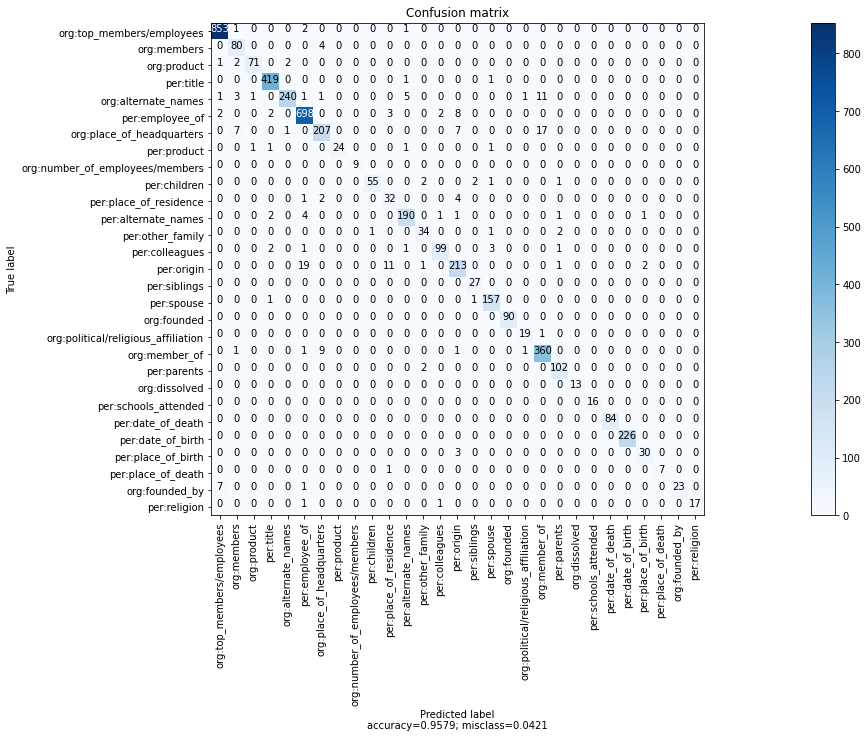

In [82]:
#labels = ['no_relation', 'relation']
labels = [ 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
plot_confusion_matrix(cm, target_names=labels, normalize = False)

In [ ]:
t_list = tokenized_train['input_ids'][0].numpy()
leng = 0
for t in full_dataset['input_ids']:
    tn = t.numpy()
    tn = np.delete(tn, np.where(tn == 0))
    leng += len(tn)
print(leng/len(full_dataset['input_ids']))

In [93]:
a = np.array([1,2,3,4,5])
print(a)

[1 2 3 4 5]


In [96]:
a[2:5] = 1

In [97]:
a

array([1, 2, 1, 1, 1])

In [98]:
a = tokenized_train['input_ids'][0].numpy()

In [99]:
print(a)

[    2 32000  8272    22  2103 32001  1453 32002 27330  2160  2416 32003
  6717  2079 10276  2096  2073  7815  2302  2440    24  2429  3909  2210
  6335 27135 11986  3876  2103  2079  1589  2165  4402 19758  2496  2359
  2062    18     3     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [104]:
np.where(a==32001)[0][0]

5

In [105]:
tokenized_train['input_ids'][0].numpy()

array([    2, 32000,  8272,    22,  2103, 32001,  1453, 32002, 27330,
        2160,  2416, 32003,  6717,  2079, 10276,  2096,  2073,  7815,
        2302,  2440,    24,  2429,  3909,  2210,  6335, 27135, 11986,
        3876,  2103,  2079,  1589,  2165,  4402, 19758,  2496,  2359,
        2062,    18,     3,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,